In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, brier_score_loss
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping
from google.colab import drive

In [ ]:
# Constants
SEED = 42
REPEATS = 5
FOLDS = 5
PCA_COMPONENTS = 200
PCA_VARIANCE = 0.9
np.random.seed(SEED)

# Mount Google Drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/widsdatathon2025'


Mounted at /content/drive


In [ ]:
# Load data with error handling
def load_data(file_path, file_type='excel'):
    try:
        if file_type == 'excel':
            return pd.read_excel(file_path)
        elif file_type == 'csv':
            return pd.read_csv(file_path)
        else:
            raise ValueError(f"Unsupported file type: {file_type}")
    except FileNotFoundError:
        raise FileNotFoundError(f"File not found: {file_path}")

# Load datasets
try:
    train_q = load_data(os.path.join(base_path, 'TRAIN_QUANTITATIVE_METADATA_new.xlsx'))
    train_c = load_data(os.path.join(base_path, 'TRAIN_CATEGORICAL_METADATA_new.xlsx'))
    test_q = load_data(os.path.join(base_path, 'TEST_QUANTITATIVE_METADATA.xlsx'))
    test_c = load_data(os.path.join(base_path, 'TEST_CATEGORICAL.xlsx'))
    train_imaging_data = load_data(os.path.join(base_path, 'TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv'), 'csv')
    test_imaging_data = load_data(os.path.join(base_path, 'TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv'), 'csv')
    labels = load_data(os.path.join(base_path, 'TRAINING_SOLUTIONS.xlsx'))
    submission_template = load_data(os.path.join(base_path, 'SAMPLE_SUBMISSION.xlsx'))
except Exception as e:
    print(f"Error loading data: {e}")
    raise

In [ ]:
# Merge data
def merge_data(quant, cat, imaging):
    combined = pd.merge(quant, cat, on="participant_id", how="inner").set_index("participant_id")
    combined = pd.merge(combined.reset_index(), imaging, on="participant_id", how="inner").set_index("participant_id")
    return combined

train_combined = merge_data(train_q, train_c, train_imaging_data)
test_combined = merge_data(test_q, test_c, test_imaging_data)

In [ ]:
train_combined.shape

(1213, 19927)

In [ ]:
# Basic Overview
print("First 5 Rows:\n", train_combined.head())
print("\nInfo:\n")
print(train_combined.info())
print("\nSummary Statistics:\n", train_combined.describe())

First 5 Rows:
                 EHQ_EHQ_Total  ColorVision_CV_Score  APQ_P_APQ_P_CP  \
participant_id                                                        
00aIpNTbG5uh           100.00                  13.0             3.0   
00fV0OyyoLfw            92.27                  14.0             3.0   
04X1eiS79T4B            86.67                  14.0             3.0   
05ocQutkURd6            93.34                  14.0             3.0   
06YUNBA9ZRLq             0.00                  14.0             8.0   

                APQ_P_APQ_P_ID  APQ_P_APQ_P_INV  APQ_P_APQ_P_OPD  \
participant_id                                                     
00aIpNTbG5uh              15.0             44.0             14.0   
00fV0OyyoLfw              12.0             35.0             25.0   
04X1eiS79T4B              21.0             37.0             18.0   
05ocQutkURd6              11.0             42.0             15.0   
06YUNBA9ZRLq              12.0             35.0             22.0   

          

# Data preprocessing

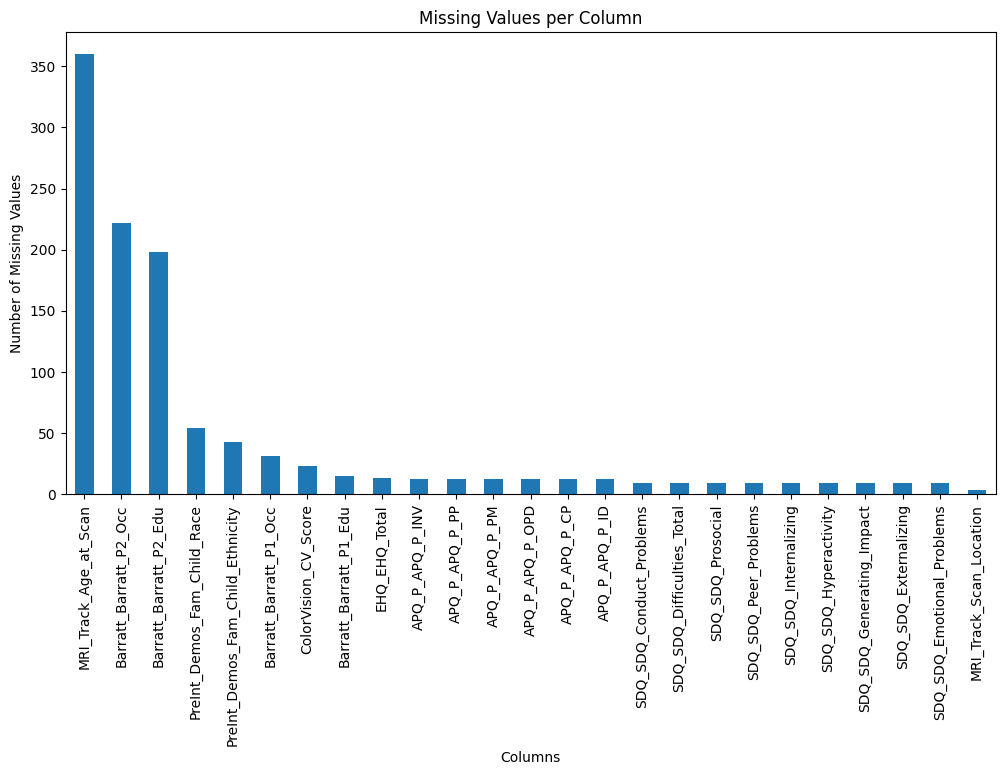

In [ ]:
# Missing Values Visualization
missing_values = train_combined.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values.sort_values(ascending=False).plot.bar(figsize=(12,6))
plt.title('Missing Values per Column')
plt.ylabel('Number of Missing Values')
plt.xlabel('Columns')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Median imputation for train_combined
train_combined = train_combined.fillna(train_combined.median())

# Median imputation for test_combined
test_combined = test_combined.fillna(test_combined.median())


In [ ]:
# Number of duplicate rows in train_combined
num_duplicates_train = train_combined.duplicated().sum()
print(f"Number of duplicate rows in train_combined: {num_duplicates_train}")

# Number of duplicate rows in test_combined
num_duplicates_test = test_combined.duplicated().sum()
print(f"Number of duplicate rows in test_combined: {num_duplicates_test}")


Number of duplicate rows in train_combined: 0
Number of duplicate rows in test_combined: 0


/tmp/ipython-input-9-789450019.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Dataset', y='Duplicates', data=dup_df, palette='viridis')


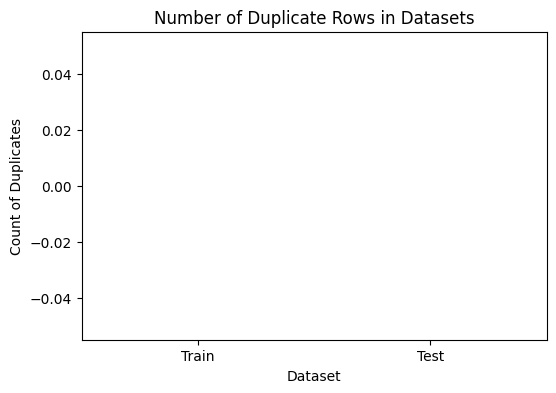

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count duplicates
num_duplicates_train = train_combined.duplicated().sum()
num_duplicates_test = test_combined.duplicated().sum()

# Prepare data for plotting
dup_data = {
    'Dataset': ['Train', 'Test'],
    'Duplicates': [num_duplicates_train, num_duplicates_test]
}

# Create DataFrame for seaborn
import pandas as pd
dup_df = pd.DataFrame(dup_data)

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x='Dataset', y='Duplicates', data=dup_df, palette='viridis')

plt.title('Number of Duplicate Rows in Datasets')
plt.ylabel('Count of Duplicates')
plt.xlabel('Dataset')
plt.show()


In [ ]:
# Standardize participant_id (No, what your standardize_ids function does is data cleaning or standardization of IDs, not normalization.)
def standardize_ids(df, id_col='participant_id'):
    if id_col not in df.columns:
        raise ValueError(f"Column {id_col} not found in DataFrame")
    df[id_col] = df[id_col].astype(str).str.strip()
    return df

# Apply ID standardization
dataframes = [train_q, train_c, test_q, test_c, train_imaging_data, test_imaging_data, labels]
for df in dataframes:
    df = standardize_ids(df)

In [ ]:
# Align with labels
labels = labels.set_index('participant_id')
common_ids = train_combined.index.intersection(labels.index)
if len(common_ids) == 0:
    raise ValueError("No common IDs between training data and labels")
train_combined = train_combined.loc[common_ids].sort_index()
labels = labels.loc[common_ids].sort_index()

# Vizualization

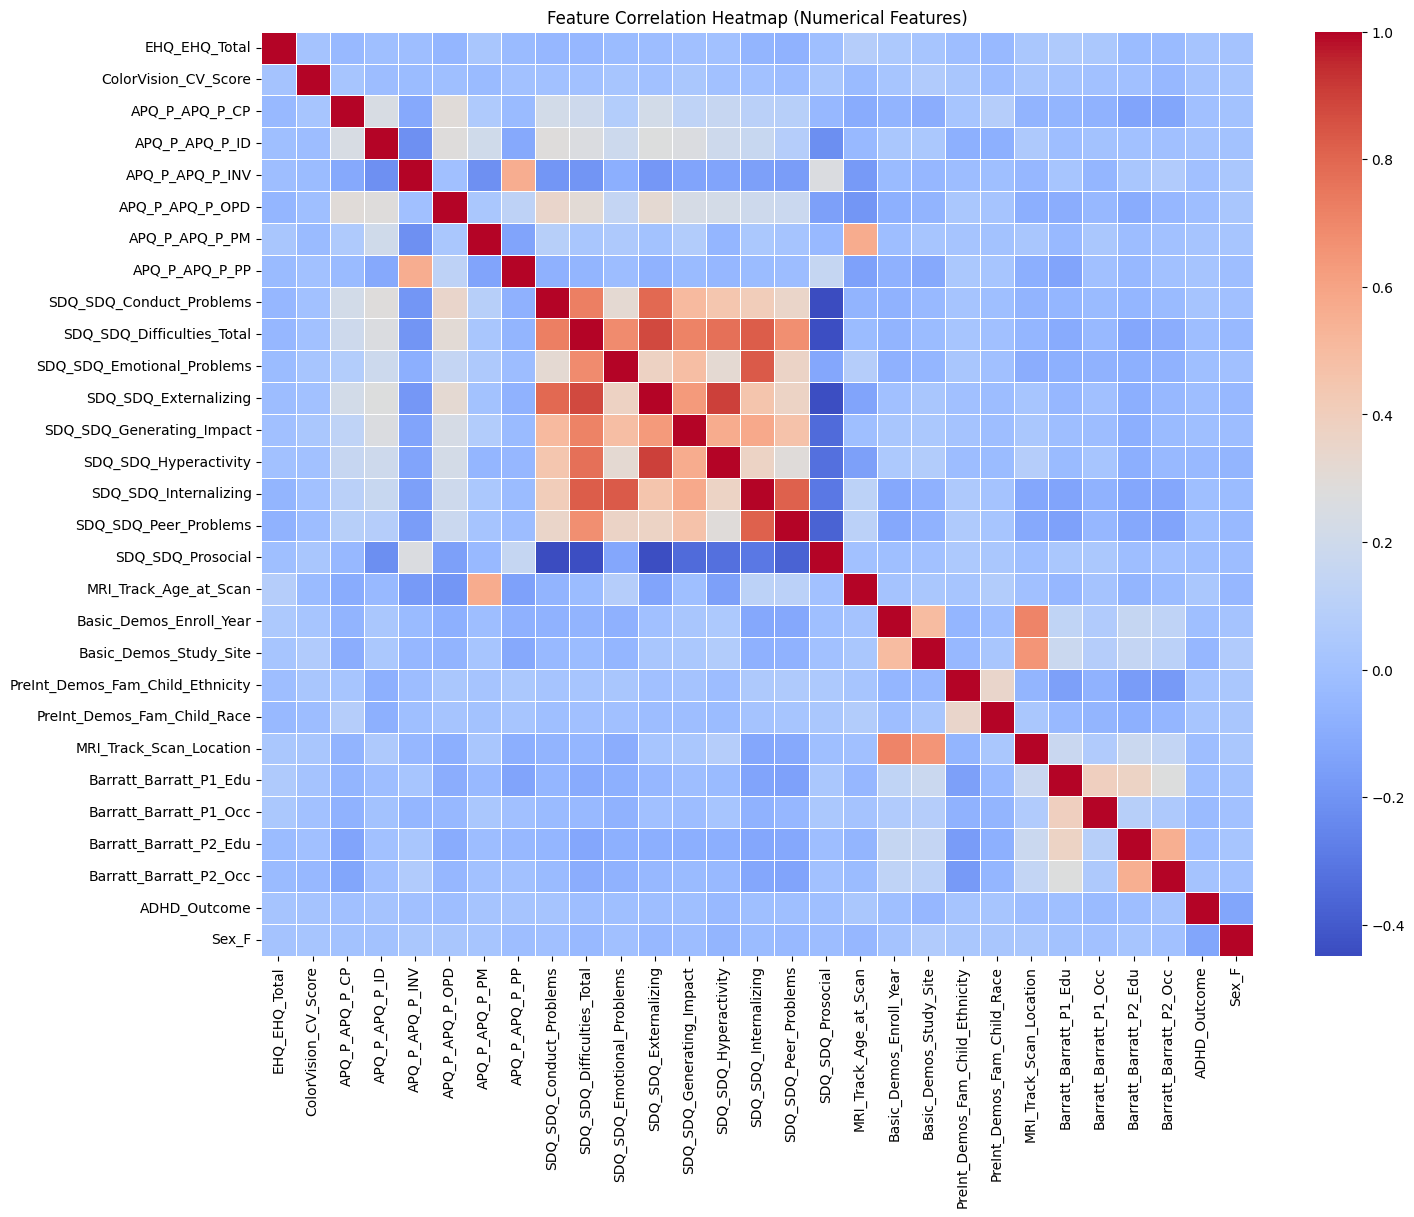

In [ ]:
# Correlation Heatmap (only for numerical columns)
plt.figure(figsize=(16,12))
sns.heatmap(train_combined.select_dtypes(include=[np.number]).corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap (Numerical Features)')
plt.show()


q.How does age at scan relate to ADHD outcome?

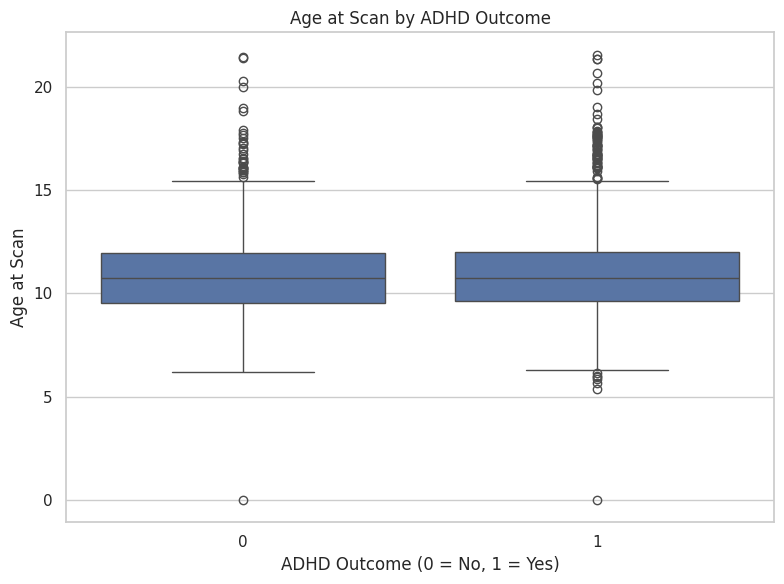

In [ ]:
sns.set(style="whitegrid")

# Merge train_combined with labels for visualization purposes
# Ensure both dataframes are indexed by participant_id before merging
merged_data = train_combined.merge(labels[['ADHD_Outcome']], left_index=True, right_index=True, how='inner')

plt.figure(figsize=(8, 6))
sns.boxplot(x='ADHD_Outcome', y='MRI_Track_Age_at_Scan', data=merged_data)
plt.title('Age at Scan by ADHD Outcome')
plt.xlabel('ADHD Outcome (0 = No, 1 = Yes)')
plt.ylabel('Age at Scan')
plt.tight_layout()
plt.show()

q.Do SDQ scores differ by ADHD status?
python
Copy
Edit


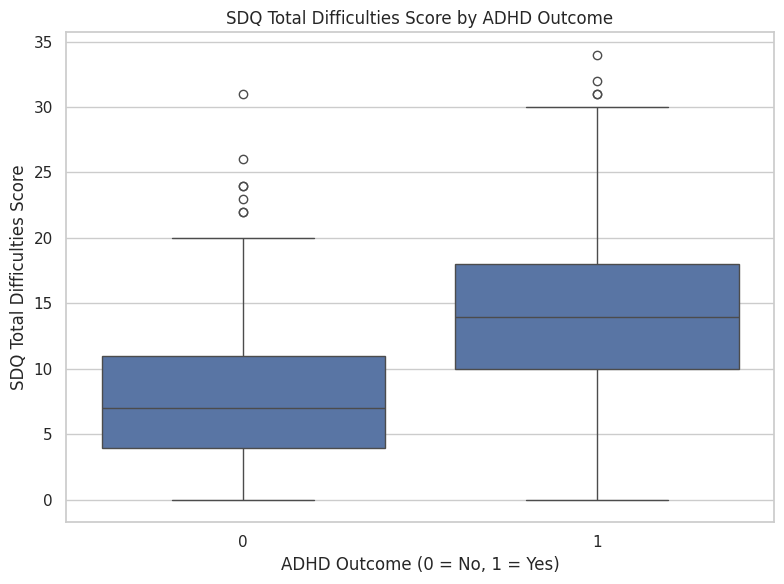

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='ADHD_Outcome', y='SDQ_SDQ_Difficulties_Total', data=merged_data)
plt.title('SDQ Total Difficulties Score by ADHD Outcome')
plt.xlabel('ADHD Outcome (0 = No, 1 = Yes)')
plt.ylabel('SDQ Total Difficulties Score')
plt.tight_layout()
plt.show()

q.Does parental education or occupation level relate to ADHD prevalence?

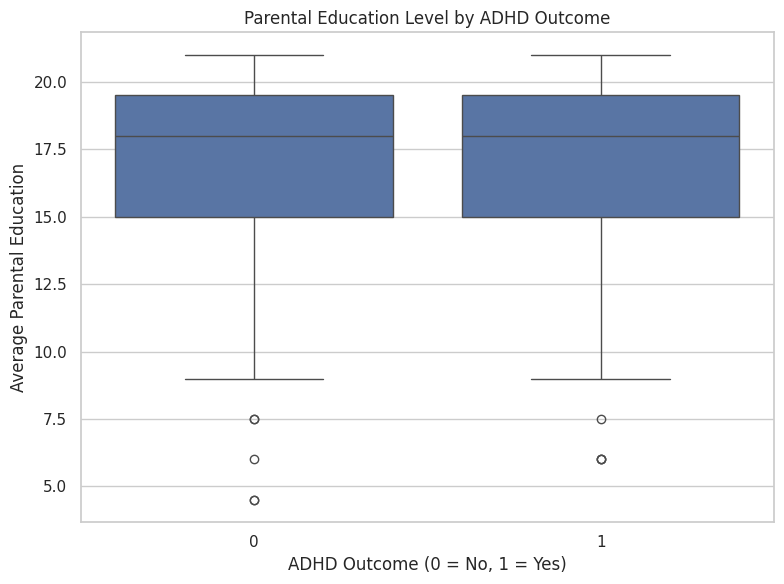

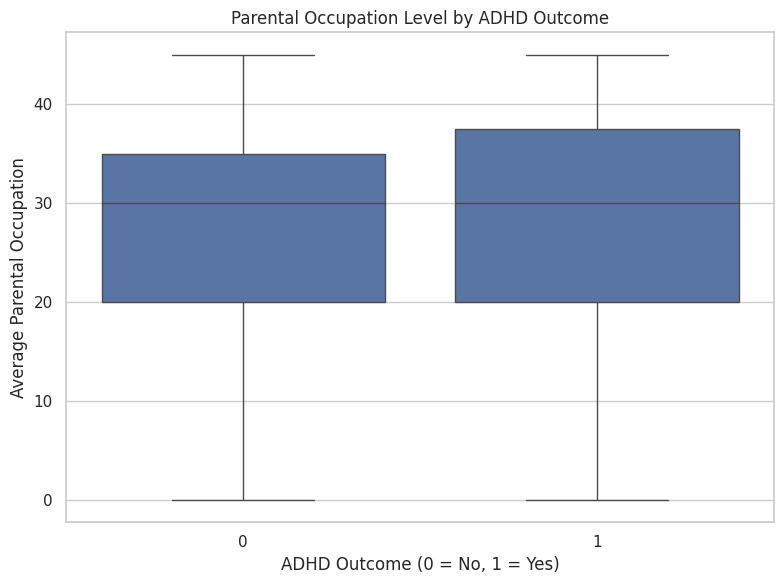

In [ ]:
# Compute average parental education and occupation
merged_data['Average_Parental_Education'] = merged_data[['Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P2_Edu']].mean(axis=1)
merged_data['Average_Parental_Occupation'] = merged_data[['Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Occ']].mean(axis=1)

# Education Level
plt.figure(figsize=(8, 6))
sns.boxplot(x='ADHD_Outcome', y='Average_Parental_Education', data=merged_data)
plt.title('Parental Education Level by ADHD Outcome')
plt.xlabel('ADHD Outcome (0 = No, 1 = Yes)')
plt.ylabel('Average Parental Education')
plt.tight_layout()
plt.show()

# Occupation Level
plt.figure(figsize=(8, 6))
sns.boxplot(x='ADHD_Outcome', y='Average_Parental_Occupation', data=merged_data)
plt.title('Parental Occupation Level by ADHD Outcome')
plt.xlabel('ADHD Outcome (0 = No, 1 = Yes)')
plt.ylabel('Average Parental Occupation')
plt.tight_layout()
plt.show()

q. Are certain racial or ethnic groups over- or under-represented in ADHD diagnoses?

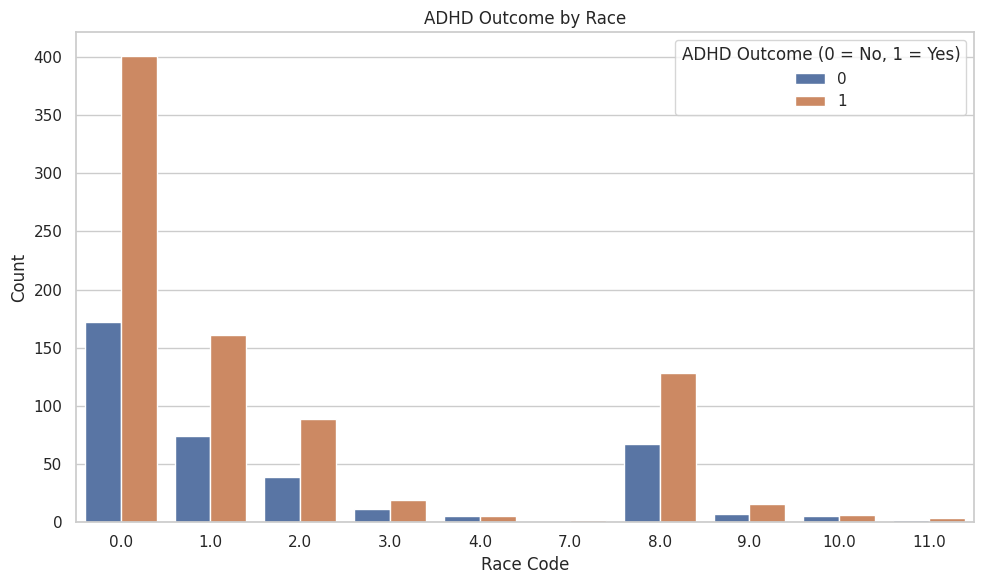

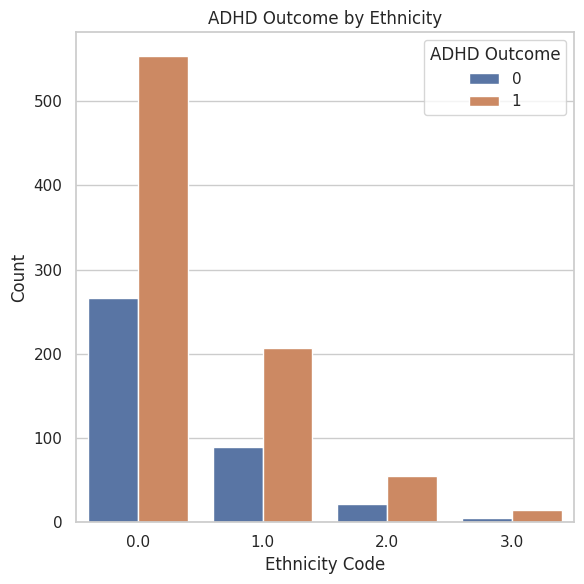

In [ ]:
# Create count plot for race vs ADHD
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_data, x='PreInt_Demos_Fam_Child_Race', hue='ADHD_Outcome')
plt.title('ADHD Outcome by Race')
plt.xlabel('Race Code')
plt.ylabel('Count')
plt.legend(title='ADHD Outcome (0 = No, 1 = Yes)')
plt.tight_layout()
plt.show()

# Ethnicity
plt.figure(figsize=(6, 6))
sns.countplot(data=merged_data, x='PreInt_Demos_Fam_Child_Ethnicity', hue='ADHD_Outcome')
plt.title('ADHD Outcome by Ethnicity')
plt.xlabel('Ethnicity Code')
plt.ylabel('Count')
plt.legend(title='ADHD Outcome')
plt.tight_layout()
plt.show()

Is there a difference in EHQ score between ADHD and non-ADHD participants?

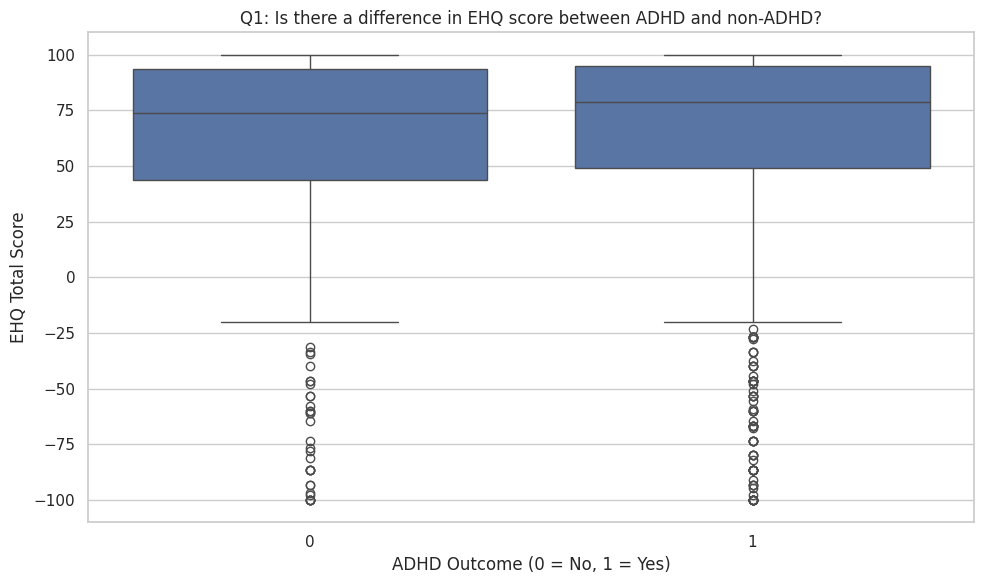

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set visualization style
sns.set(style="whitegrid")

#EHQ scores by ADHD status
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_data, x='ADHD_Outcome', y='EHQ_EHQ_Total')
plt.title("Q1: Is there a difference in EHQ score between ADHD and non-ADHD?")
plt.xlabel("ADHD Outcome (0 = No, 1 = Yes)")
plt.ylabel("EHQ Total Score")
plt.tight_layout()
plt.show()

Does ADHD prevalence differ by sex?Does ADHD prevalence differ by sex?

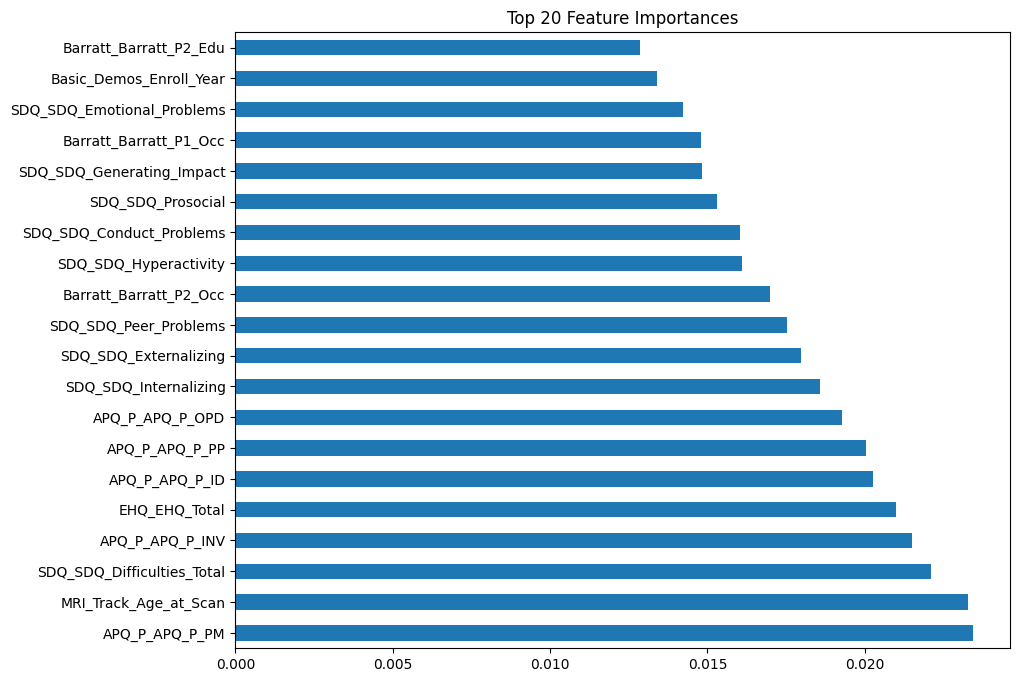

In [ ]:
# OPTIONAL: Feature Importance (only if target column exists)
try:
    target_col = 'ADHD_Outcome'  # Adjust if needed
    X = merged_data.drop(columns=[target_col])
    y = merged_data[target_col]

    # Fill missing values
    X = X.fillna(X.median(numeric_only=True))

    # Convert categorical columns to numeric if necessary
    X = pd.get_dummies(X, drop_first=True)

    # Split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train RandomForest
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Feature Importance
    importances = model.feature_importances_
    feat_importances = pd.Series(importances, index=X.columns)
    feat_importances.nlargest(20).plot(kind='barh', figsize=(10,8))
    plt.title('Top 20 Feature Importances')
    plt.show()
except Exception as e:
    print("Skipping feature importance plotting due to:", e)


In [ ]:

# Drop unnecessary columns
drop_cols = [
    "Basic_Demos_Study_Site", "MRI_Track_Scan_Location", "PreInt_Demos_Fam_Child_Ethnicity",
    "PreInt_Demos_Fam_Child_Race", 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Occ'
]
train_combined.drop(columns=[col for col in drop_cols if col in train_combined.columns], inplace=True)
test_combined.drop(columns=[col for col in drop_cols if col in test_combined.columns], inplace=True)


In [ ]:

# Identify imaging columns
non_imaging_cols = list(set(train_q.columns).union(set(train_c.columns)) - {'participant_id'})
imaging_cols = [col for col in train_combined.columns if col not in non_imaging_cols]


In [ ]:

# Identify imaging columns
non_imaging_cols = list(set(train_q.columns).union(set(train_c.columns)) - {'participant_id'})
imaging_cols = [col for col in train_combined.columns if col not in non_imaging_cols]


In [ ]:

# Apply PCA to imaging data
def apply_pca(train_data, test_data, cols, n_components, variance_threshold):
    pca = PCA(n_components=min(n_components, len(cols)), random_state=SEED)
    train_pca = pca.fit_transform(train_data[cols])
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    n_selected = np.searchsorted(explained_variance, variance_threshold) + 1
    n_selected = min(n_selected, n_components, len(cols))

    pca = PCA(n_components=n_selected, random_state=SEED)
    train_pca = pca.fit_transform(train_data[cols])
    test_pca = pca.transform(test_data[cols])

    pca_cols = [f'PCA_{i+1}' for i in range(n_selected)]
    return (pd.DataFrame(train_pca, index=train_data.index, columns=pca_cols),
            pd.DataFrame(test_pca, index=test_data.index, columns=pca_cols))

train_imaging_pca, test_imaging_pca = apply_pca(train_combined, test_combined, imaging_cols, PCA_COMPONENTS, PCA_VARIANCE)


In [ ]:
# Combine PCA features with non-imaging data
# Get the current non-imaging columns in train_combined
current_non_imaging_cols = [col for col in non_imaging_cols if col in train_combined.columns]

train_combined = pd.concat([train_combined[current_non_imaging_cols], train_imaging_pca], axis=1)
test_combined = pd.concat([test_combined[current_non_imaging_cols], test_imaging_pca], axis=1)

# Standardize features
scaler = StandardScaler()
train_combined = pd.DataFrame(scaler.fit_transform(train_combined), columns=train_combined.columns, index=train_combined.index)
test_combined = pd.DataFrame(scaler.transform(test_combined), columns=test_combined.columns, index=test_combined.index)


In [ ]:
# Feature sets
features_sex = [
    'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Conduct_Problems',
    'SDQ_SDQ_Peer_Problems', 'MRI_Track_Age_at_Scan', 'EHQ_EHQ_Total'
] + list(train_imaging_pca.columns)
features_adhd = [
    'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
    'SDQ_SDQ_Conduct_Problems', 'MRI_Track_Age_at_Scan', 'sex_proba', 'I_SDQ_SDQ_Hyperactivity'
] + list(train_imaging_pca.columns)
interactions = ['SDQ_SDQ_Hyperactivity']

In [ ]:
# Evaluation metrics
def eval_metrics(y_true, y_pred, weights, label="None", thresh=0.5):
    brier = brier_score_loss(y_true, y_pred)
    f1 = f1_score(y_true, (y_pred > thresh).astype(int), sample_weight=weights)
    print(f"{label} -> Brier Score: {brier:.4f}, F1: {f1:.4f}")
    return brier, f1

# Assuming y_sex and y_adhd are derived from your labels DataFrame
y_sex = labels['Sex_F'].values  # Replace 'sex' with the actual column name for sex in your labels DataFrame
y_adhd = labels['ADHD_Outcome'].values  # Replace 'adhd' with the actual column name for ADHD in your labels DataFrame


# XGBoost parameters
xgb_params_sex = {
    'n_estimators': 300,
    'max_depth': 3,
    'learning_rate': 0.05,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'reg_alpha': 1.0,
    'reg_lambda': 1.0,
    'eval_metric': 'logloss',
    'scale_pos_weight': len(y_sex[y_sex == 0]) / len(y_sex[y_sex == 1])
}

xgb_params_adhd = {
    'n_estimators': 300,
    'max_depth': 3,
    'learning_rate': 0.05,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'reg_alpha': 1.0,
    'reg_lambda': 1.0,
    'eval_metric': 'logloss',
    'scale_pos_weight': len(y_adhd[y_adhd == 0]) / len(y_adhd[y_adhd == 1])
}

In [ ]:
# Cross-validation with random state variation
scores_sex = []
scores_adhd = []
sex_oof = np.zeros(len(y_sex))
adhd_oof = np.zeros(len(y_adhd))
sex_proba_test = np.zeros(len(test_combined))
adhd_proba_test = np.zeros(len(test_combined))

In [ ]:
# Assuming 'combinations' should be based on both 'y_sex' and 'y_adhd'
# Create a new column 'combinations' in labels based on 'Sex_F' and 'ADHD_Outcome'
labels['combinations'] = labels['Sex_F'].astype(str) + labels['ADHD_Outcome'].astype(str)

# Get the combinations for splitting
combinations = labels['combinations']

rskf = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=REPEATS, random_state=SEED)
for fold, (train_idx, val_idx) in enumerate(rskf.split(train_combined, combinations), 1):
    print(f"\n=== Fold {fold} ===")
    X_train = train_combined.iloc[train_idx].copy()
    X_val = train_combined.iloc[val_idx].copy()

    # Access y_adhd, y_sex, and combinations using iloc with train_idx and val_idx
    y_train_adhd = y_adhd[train_idx]
    y_val_adhd = y_adhd[val_idx]
    y_train_sex = y_sex[train_idx]
    y_val_sex = y_sex[val_idx]
    weights_train = np.where(combinations.iloc[train_idx] == "11", 2, 1)
    weights = np.where(combinations.iloc[val_idx] == "11", 2, 1)

    # Sex prediction
    model_sex = XGBClassifier(**xgb_params_sex, callbacks=[EarlyStopping(rounds=50, save_best=True)])
    model_sex.fit(X_train[features_sex], y_train_sex, sample_weight=weights_train, eval_set=[(X_val[features_sex], y_val_sex)], verbose=False)
    sex_val = model_sex.predict_proba(X_val[features_sex])[:, 1]
    sex_oof[val_idx] += sex_val / REPEATS
    sex_brier, sex_f1 = eval_metrics(y_val_sex, sex_val, weights, "Sex_F")
    scores_sex.append((sex_brier, sex_f1))

    # ADHD prediction
    X_train["sex_proba"] = model_sex.predict_proba(X_train[features_sex])[:, 1]
    X_val["sex_proba"] = sex_val
    for interaction in interactions:
        X_train[f"I_{interaction}"] = X_train[interaction] * X_train["sex_proba"]
        X_val[f"I_{interaction}"] = X_val[interaction] * X_val["sex_proba"]

    model_adhd = XGBClassifier(**xgb_params_adhd, callbacks=[EarlyStopping(rounds=50, save_best=True)])
    model_adhd.fit(X_train[features_adhd], y_train_adhd, sample_weight=weights_train, eval_set=[(X_val[features_adhd], y_val_adhd)], verbose=False)
    adhd_val = model_adhd.predict_proba(X_val[features_adhd])[:, 1]
    adhd_oof[val_idx] += adhd_val / REPEATS
    adhd_brier, adhd_f1 = eval_metrics(y_val_adhd, adhd_val, weights, "Outcome ADHD")
    scores_adhd.append((adhd_brier, adhd_f1))

    # Test predictions
    sex_proba_test += model_sex.predict_proba(test_combined[features_sex])[:, 1] / (FOLDS * REPEATS)
    test_combined["sex_proba"] = sex_proba_test
    for interaction in interactions:
        test_combined[f"I_{interaction}"] = test_combined[interaction] * test_combined["sex_proba"]
    adhd_proba_test += model_adhd.predict_proba(test_combined[features_adhd])[:, 1] / (FOLDS * REPEATS)



=== Fold 1 ===
Sex_F -> Brier Score: 0.2184, F1: 0.5440
Outcome ADHD -> Brier Score: 0.1521, F1: 0.8511

=== Fold 2 ===
Sex_F -> Brier Score: 0.1961, F1: 0.5873
Outcome ADHD -> Brier Score: 0.1723, F1: 0.8060

=== Fold 3 ===
Sex_F -> Brier Score: 0.2020, F1: 0.5984
Outcome ADHD -> Brier Score: 0.1608, F1: 0.8200

=== Fold 4 ===
Sex_F -> Brier Score: 0.1963, F1: 0.6220
Outcome ADHD -> Brier Score: 0.1511, F1: 0.8416

=== Fold 5 ===
Sex_F -> Brier Score: 0.2040, F1: 0.5935
Outcome ADHD -> Brier Score: 0.1586, F1: 0.8350

=== Fold 6 ===
Sex_F -> Brier Score: 0.2153, F1: 0.5844
Outcome ADHD -> Brier Score: 0.1564, F1: 0.8510

=== Fold 7 ===
Sex_F -> Brier Score: 0.2072, F1: 0.5887
Outcome ADHD -> Brier Score: 0.1553, F1: 0.8191

=== Fold 8 ===
Sex_F -> Brier Score: 0.2069, F1: 0.5169
Outcome ADHD -> Brier Score: 0.1580, F1: 0.8390

=== Fold 9 ===
Sex_F -> Brier Score: 0.2170, F1: 0.5294
Outcome ADHD -> Brier Score: 0.1726, F1: 0.8060

=== Fold 10 ===
Sex_F -> Brier Score: 0.2038, F1: 0.53

In [ ]:

# Print CV results
print(f"\n=== CV Results ===")
print(f"Sex Mean Brier Score: {np.mean([s[0] for s in scores_sex]):.4f} ± {np.std([s[0] for s in scores_sex]):.4f}")
print(f"Sex Mean F1: {np.mean([s[1] for s in scores_sex]):.4f} ± {np.std([s[1] for s in scores_sex]):.4f}")
print(f"ADHD Mean Brier Score: {np.mean([s[0] for s in scores_adhd]):.4f} ± {np.std([s[0] for s in scores_adhd]):.4f}")
print(f"ADHD Mean F1: {np.mean([s[1] for s in scores_adhd]):.4f} ± {np.std([s[1] for s in scores_adhd]):.4f}")



=== CV Results ===
Sex Mean Brier Score: 0.2097 ± 0.0099
Sex Mean F1: 0.5666 ± 0.0362
ADHD Mean Brier Score: 0.1616 ± 0.0083
ADHD Mean F1: 0.8292 ± 0.0162


In [ ]:
# Threshold optimization
weights = np.where(combinations == "11", 2, 1)
thresholds = np.linspace(0.3, 0.7, 100)
sex_scores = [f1_score(y_sex, (sex_oof > t).astype(int), sample_weight=weights) for t in thresholds]
adhd_scores = [f1_score(y_adhd, (adhd_oof > t).astype(int), sample_weight=weights) for t in thresholds]
best_sex_threshold = thresholds[np.argmax(sex_scores)]
best_adhd_threshold = thresholds[np.argmax(adhd_scores)]
print(f"\nOptimized thresholds - Sex_F: {best_sex_threshold:.4f}, ADHD: {best_adhd_threshold:.4f}")


Optimized thresholds - Sex_F: 0.3566, ADHD: 0.3000


In [ ]:
# Final model training
model_sex_final = XGBClassifier(**xgb_params_sex, callbacks=[EarlyStopping(rounds=50, save_best=True)])
model_sex_final.fit(train_combined[features_sex], y_sex, sample_weight=weights, eval_set=[(train_combined[features_sex], y_sex)], verbose=False)

train_combined["sex_proba"] = model_sex_final.predict_proba(train_combined[features_sex])[:, 1]
for interaction in interactions:
    train_combined[f"I_{interaction}"] = train_combined[interaction] * train_combined["sex_proba"]

model_adhd_final = XGBClassifier(**xgb_params_adhd, callbacks=[EarlyStopping(rounds=50, save_best=True)])
model_adhd_final.fit(train_combined[features_adhd], y_adhd, sample_weight=weights, eval_set=[(train_combined[features_adhd], y_adhd)], verbose=False)

# Final test predictions
test_combined["sex_proba"] = model_sex_final.predict_proba(test_combined[features_sex])[:, 1]
for interaction in interactions:
    test_combined[f"I_{interaction}"] = test_combined[interaction] * test_combined["sex_proba"]
adhd_proba_test = model_adhd_final.predict_proba(test_combined[features_adhd])[:, 1]
sex_proba_test = model_sex_final.predict_proba(test_combined[features_sex])[:, 1]


In [ ]:
# Print number of 1's and 0's
print("\nPrediction Distribution:")
print("Sex_F -> Number of 1's:", np.sum(sex_proba_test))
print("Sex_F -> Number of 0's:", len(sex_proba_test) - np.sum(sex_proba_test))
print("ADHD_Outcome -> Number of 1's:", np.sum(adhd_proba_test))
print("ADHD_Outcome -> Number of 0's:", len(adhd_proba_test) - np.sum(adhd_proba_test))


Prediction Distribution:
Sex_F -> Number of 1's: 150.09494
Sex_F -> Number of 0's: 153.90506
ADHD_Outcome -> Number of 1's: 178.0336
ADHD_Outcome -> Number of 0's: 125.9664


In [ ]:
# Submission
submission = submission_template.copy()
submission["ADHD_Outcome"] = (adhd_proba_test > best_adhd_threshold).astype(int)
submission["Sex_F"] = (sex_proba_test > best_sex_threshold).astype(int)

In [ ]:
print(f"\n=== Submission Distribution ===")
print(f"ADHD_Outcome:\n{submission['ADHD_Outcome'].value_counts()}")
print(f"Sex_F:\n{submission['Sex_F'].value_counts()}")


=== Submission Distribution ===
ADHD_Outcome:
ADHD_Outcome
1    228
0     76
Name: count, dtype: int64
Sex_F:
Sex_F
1    220
0     84
Name: count, dtype: int64


In [ ]:
from sklearn.metrics import precision_score, recall_score

# Calculate precision and recall for sex prediction
sex_precision = precision_score(y_sex, (sex_oof > best_sex_threshold).astype(int), sample_weight=weights)
sex_recall = recall_score(y_sex, (sex_oof > best_sex_threshold).astype(int), sample_weight=weights)

print(f"\n--- Sex Prediction ---")
print(f"Precision: {sex_precision:.4f}")
print(f"Recall: {sex_recall:.4f}")

# Calculate precision and recall for ADHD prediction
adhd_precision = precision_score(y_adhd, (adhd_oof > best_adhd_threshold).astype(int), sample_weight=weights)
adhd_recall = recall_score(y_adhd, (adhd_oof > best_adhd_threshold).astype(int), sample_weight=weights)

print(f"\n--- ADHD Prediction ---")
print(f"Precision: {adhd_precision:.4f}")
print(f"Recall: {adhd_recall:.4f}")


--- Sex Prediction ---
Precision: 0.5789
Recall: 0.8153

--- ADHD Prediction ---
Precision: 0.8469
Recall: 0.9158


In [ ]:
# Save and download submission
submission_path = os.path.join(base_path, 'submission_xgb_pca_optimized.csv')
submission.to_csv(submission_path, index=False)
from google.colab import files
files.download(submission_path)

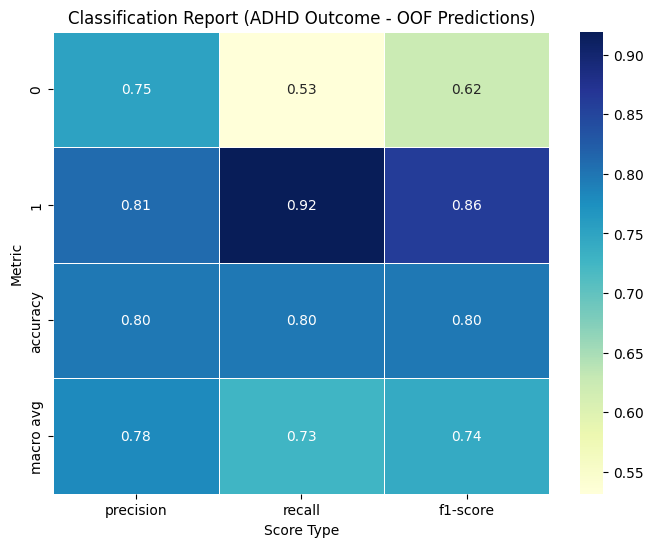

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming adhd_oof, y_adhd, best_adhd_threshold are available from your previous code execution.
# For demonstration, let's assume y_adhd is a numpy array of true labels (0 or 1)
# and adhd_oof is a numpy array of predicted probabilities.
# If you want the report for Sex_F, replace y_adhd with y_sex and adhd_oof with sex_oof,
# and best_adhd_threshold with best_sex_threshold.

# 1. Generate the classification report
# Convert probabilities to binary predictions using the optimized threshold
adhd_predictions_binary = (adhd_oof > best_adhd_threshold).astype(int)

# Get the classification report as a dictionary
report_dict = classification_report(y_adhd, adhd_predictions_binary, output_dict=True)

# Convert the dictionary to a pandas DataFrame for easier plotting
df_report = pd.DataFrame(report_dict).transpose()

# We usually only want to plot precision, recall, and f1-score for classes '0' and '1',
# and also 'accuracy' and 'macro avg'.
# You might need to adjust column selection based on your specific report_dict structure.
metrics_to_plot = ['precision', 'recall', 'f1-score']
rows_to_plot = ['0', '1', 'accuracy', 'macro avg']

df_plot = df_report.loc[rows_to_plot, metrics_to_plot]

# Convert 'accuracy' row to have values for all metrics columns for consistent heatmap display
# (as accuracy is usually a single value in the report)
# df_plot.loc['accuracy', ['precision', 'recall', 'f1-score']] = df_report.loc['accuracy', 'f1-score'] # Or 'accuracy' if directly available

# Ensure all values are numeric
df_plot = df_plot.apply(pd.to_numeric, errors='coerce')


# 2. Plot the heatmap
plt.figure(figsize=(8, 6)) # Adjust size as needed
sns.heatmap(df_plot, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=.5)
plt.title('Classification Report (ADHD Outcome - OOF Predictions)')
plt.ylabel('Metric')
plt.xlabel('Score Type')
plt.show()

# To get the matrix for Sex_F, you would repeat the above steps:
# sex_predictions_binary = (sex_oof > best_sex_threshold).astype(int)
# report_sex_dict = classification_report(y_sex, sex_predictions_binary, output_dict=True)
# df_report_sex = pd.DataFrame(report_sex_dict).transpose()
# df_plot_sex = df_report_sex.loc[rows_to_plot, metrics_to_plot]
# df_plot_sex = df_plot_sex.apply(pd.to_numeric, errors='coerce')
# plt.figure(figsize=(8, 6))
# sns.heatmap(df_plot_sex, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=.5)
# plt.title('Classification Report (Sex_F - OOF Predictions)')
# plt.ylabel('Metric')
# plt.xlabel('Score Type')
# plt.show()